# **О Google Colab**

# **Скачать проект**

In [ ]:
import gdown
url = "https://drive.google.com/drive/folders/1Em0IqzBt-zac08lYnsTlVh3ugth0nHcb?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

In [ ]:
# Разархивируем данные
!unzip /MRI_School_ML/Data/mri.zip  -d row_data

# **О датасете**

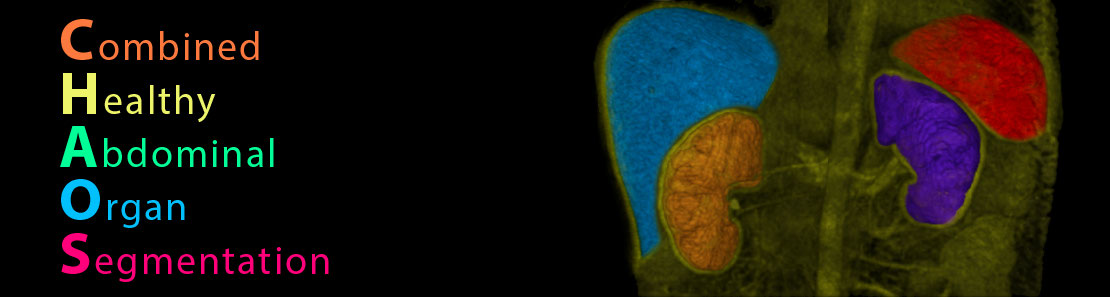

https://chaos.grand-challenge.org/

Segmentation of liver from computed tomography (**CT**) data sets, which are acquired at portal phase after contrast agent injection for pre-evaluation of living donated liver transplantation donors.

Segmentation of four abdominal organs (i.e. liver, spleen, right and left kidneys) from magnetic resonance imaging (MRI) data sets acquired with two different sequences (**T1-DUAL and T2-SPIR**).

# **Импорт установленных пакетов**

In [ ]:
# import modules
import os
import datetime
import numpy as np

import cv2
import pydicom

# DL packages
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam

# Visualization
import matplotlib.pyplot as plt
# === user moudels
from MRI_School_ML.scr.models import unet_model
from MRI_School_ML.scr.metrics import dice_coef, dice_soft_coef
from MRI_School_ML.scr.utils import class_binarization, mask_on_image

# **Чтение и просмотр данных**

In [ ]:
# Чтение DICOM данные
im_example = '/content/row_data/mri/train/20/DICOM_anon'
central_slice_n = round(len(os.listdir(im_example))/2)
dicom_file = pydicom.dcmread(os.path.join(im_example, os.listdir(im_example)[central_slice_n]))
dicom_file = pydicom.dcmread('/content/row_data/mri/train/20/DICOM_anon/IMG-0029-00011.dcm')
# show subject info
print(dicom_file)

In [ ]:
# show image
im = dicom_file.pixel_array
plt.imshow(im, cmap='gray')

In [ ]:
# choose class
class_labels = {'Liver': 63, 'Right_kidney': 126, 'Left_kidney': 189, 'Spleen': 252}
class_name = 'Liver'
class_label = class_labels[class_name]


im_example = '/content/row_data/mri/train/20/DICOM_anon'
mask_example = '/content/row_data/mri/train/20/Ground'
im_list = os.listdir(im_example)
mask_list = os.listdir(mask_example)

for i in  mask_list:
  # get files path
  mask_path = os.path.join(mask_example, i)
  image_path = os.path.join(mask_path.split('Ground')[0], 'DICOM_anon', i.split('png')[0] + 'dcm')
  print(image_path, mask_path)

  # read dicom file and get pixel array
  dcm_file = pydicom.dcmread(image_path)
  im = dcm_file.pixel_array
  # read mask
  mask = cv2.imread(mask_path)

  if np.sum(mask) !=0:
    if class_label in np.unique(mask):
      binary_mask = class_binarization(mask, class_label)
      colored_image = mask_on_image(im, binary_mask)

    # visualization
      plt.figure()
      plt.subplot(1, 4, 1)
      plt.imshow(im, cmap='gray')
      plt.title(image_path.split('DICOM_anon')[1][1:-4])
      plt.subplot(1, 4, 2)
      plt.imshow(mask)
      plt.title(mask_path.split('Ground')[1][1:-4])
      plt.subplot(1, 4, 3)
      plt.imshow(binary_mask)
      plt.title(class_name)
      plt.subplot(1, 4, 4)
      plt.imshow(colored_image)
      plt.title('image + mask')




# **Подготовка данных к обучению**

# Разметка в medseg  

https://www.medseg.ai/

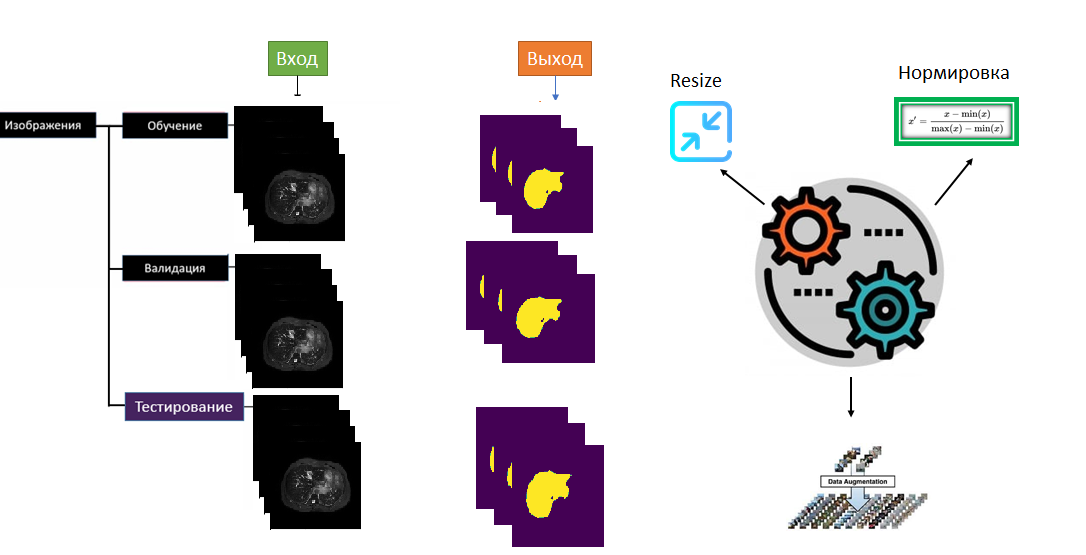

# Patient-wise split
# No converting into range[0..255]

In [ ]:
# choose class
class_labels = {'Liver': 63, 'Right_kidney': 126, 'Left_kidney': 189, 'Spleen': 252}
class_name = 'Liver'
class_label = class_labels[class_name]

# choose the dataset
subsets_path = {'train': r'row_data/mri/train', 'test': r'row_data/mri/test', 'val': r'row_data/mri/val'}
subset = 'train'
path = subsets_path[subset]
tr_im, tr_masks = [], []

x = []
y = []
for address, dirs, files in os.walk(path):
    if 'Ground' in address and len(files) != 0:
        print(f' .....................идет обработка папки {address}  ...................................')
        for mask_file in files:
            im_path = os.path.join(address.split('Ground')[0], 'DICOM_anon', mask_file.split('png')[0] + 'dcm')
            msk_path = os.path.join(address, mask_file)
            print(im_path.split('DICOM_anon')[1] ,  msk_path.split('Ground')[1])
            assert im_path.split('DICOM_anon')[1][1:-4] == msk_path.split('Ground')[1][1:-4], 'Маска не соответствует изображению'
            # read mask
            mask = cv2.imread(msk_path)
            # mask resizing 256x256
            if class_label in np.unique(mask):
                # mask_binarization
                binary_mask = class_binarization(mask, class_label)
                resized_mask = cv2.resize(binary_mask, (256, 256), interpolation=cv2.INTER_NEAREST)
                assert np.unique(resized_mask)[0] == 0 and np.unique(resized_mask)[1]== 1, 'Маска неверна'
                # plt.imshow(resized_mask)
                # plt.show()
                y.append(resized_mask)
                # read dicom data
                dcm_file = pydicom.dcmread(im_path)
                im = dcm_file.pixel_array
                # resize image 256x256
                resized_im = cv2.resize(im, (256, 256))
                norm_im = (resized_im-np.min(resized_im))/(np.max(resized_im)-np.min(resized_im))
                x.append(norm_im)
# convert list 2 array
x = np.array(x)
y_2 = np.array(y)
print(x.shape, y_2.shape)
print(f'{class_name} {subset} subset size = {x.shape[0]}')
# save subset
os.makedirs('dataset_preprocessed', exist_ok=True)
np.save(f'dataset_preprocessed/{class_name}_image_{subset}.npy', x)
np.save(f'dataset_preprocessed/{class_name}_mask_{subset}.npy', y_2)

# **Создание и настройка нейросети**

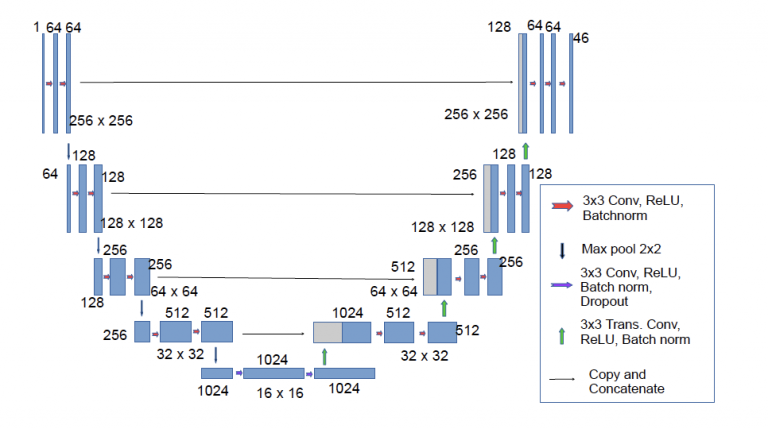

In [ ]:
# # create the model
model = unet_model(image_shape=(256, 256, 1))
# # # compile model
opt = Adam(lr=0.0002)
model.compile(loss='BinaryCrossentropy', optimizer=opt,  metrics=[dice_soft_coef])
print(model.summary())

In [ ]:
# load train data
x_train = np.load('dataset_preprocessed/Liver_image_train.npy', allow_pickle=True)
x_train = np.asarray(x_train).astype('float32')
y_train = np.load('dataset_preprocessed/Liver_mask_train.npy', allow_pickle=True)
y_train = np.asarray(y_train)
# load test data
x_test = np.load('dataset_preprocessed/Liver_image_test.npy', allow_pickle=True)
x_test = np.asarray(x_test).astype('float32')
y_test = np.load('dataset_preprocessed/Liver_mask_test.npy', allow_pickle=True)
y_test = np.asarray(y_test)

# load val data
x_val = np.load('dataset_preprocessed/Liver_image_val.npy', allow_pickle=True)
x_val = np.asarray(x_val).astype('float32')
y_val = np.load('dataset_preprocessed/Liver_mask_val.npy', allow_pickle=True)
y_val = np.asarray(y_val)

# x_train = np.expand_dims(x_train, axis=-1)
# y_train = np.expand_dims(y_train, axis=-1)
# x_test = np.expand_dims(x_test, axis=-1)
# y_test = np.expand_dims(y_test, axis=-1)
# x_val = np.expand_dims(x_val, axis=-1)
# y_val = np.expand_dims(y_val, axis=-1)


print(f'train subset size = {x_train.shape} \ntest subset size = {x_test.shape} \nvalidation subset size = {x_val.shape}')
print(f'train subset size = {y_train.shape} \ntest subset size = {y_test.shape} \nvalidation subset size = {y_val.shape}')

In [ ]:
i = 50
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[i, :, :], cmap='gray')
plt.title('image')
plt.subplot(1, 2, 2)
plt.imshow(y_train[i, :, :])
plt.title('mask')


# **Обучение сети**

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(x_train, y_train, epochs=8, validation_data=(x_val, y_val), verbose=1)

In [ ]:
# plot the training process
plt.figure(figsize=[10, 8])
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_soft_coef'])
plt.plot(history.history['val_dice_soft_coef'])
plt.xlabel('epoch')
plt.title('Dice coef')
plt.ylabel('Dice coef')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# **Сохранить модель с весами**

In [ ]:
# # save the trained model
saved_model_name = 'model_' + str(datetime.datetime.now().strftime("%m%d%Y%H%M%S")) + '.h5'
os.makedirs('saved_model', exist_ok=True)
model.save('saved_model/' + saved_model_name)

# **Применение обученной модели**

In [ ]:
trained_model = '/content/saved_model/model_07102024113953.h5'
# load and test the model
saved_model = tf.keras.models.load_model(trained_model,
                                         custom_objects={'metrics': dice_soft_coef}, compile=False)

i = 3
predicted_msk = saved_model.predict(np.expand_dims(x_test[i, :, :], axis=0))




plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(x_test[i, :, :], cmap='gray')
plt.title('image')
plt.subplot(1, 3, 2)
plt.imshow(y_test[i, :, :])
plt.title('GT mask')
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predicted_msk))
plt.title('Predicted mask')

# **Дообучение нейросети**

In [ ]:
saved_model = tf.keras.models.load_model(trained_model,
                                         custom_objects={'metrics': dice_soft_coef}, compile=False)
# # # compile model
opt = Adam(lr=0.0002)
saved_model.compile(loss='BinaryCrossentropy', optimizer=opt, metrics=[dice_soft_coef])

with tf.device('/GPU:0'):
    history = saved_model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val), verbose=1)

In [ ]:
# plot the training process
plt.figure(figsize=[8, 8])
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_soft_coef'])
plt.plot(history.history['val_dice_soft_coef'])
plt.xlabel('epoch')
plt.title('Dice coef')
plt.ylabel('Dice coef')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# **Переобучение нейросети | Решение**

**Аугментация данных**

In [ ]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


def aug_transforms():
    return [
        # A.VerticalFlip(p=1),
        # A.HorizontalFlip(p=1),
        A.Rotate(limit=(-90, 90), interpolation=cv2.INTER_NEAREST, border_mode=cv2.BORDER_CONSTANT, value=None, mask_value=None,
                 always_apply=False, p=1),

        A.ElasticTransform(alpha=20, sigma=50, alpha_affine=8,
                           interpolation=cv2.INTER_NEAREST, border_mode=cv2.BORDER_CONSTANT, value=None,
                           mask_value=None, always_apply=False, approximate=False, p=1),

        # A.GridDistortion(num_steps=20, distort_limit=0.2, interpolation=cv2.INTER_NEAREST,
        #                     border_mode=cv2.BORDER_CONSTANT, value=None, mask_value=None,
        #                     always_apply=False, p=1)
        ]

aug = A.Compose(aug_transforms())
np.random.seed(7)


aug_x_train = []
aug_y_train = []
for i in range(0, len(x_train)):
    image = x_train[i, :, :]
    mask =  y_train[i, :, :]

    # Augment an image
    for j in range(5):
        transformed = aug(image=image, mask=mask)
        transformed_image, transformed_mask = transformed["image"], transformed["mask"]
        aug_x_train.append(transformed_image)
        aug_y_train.append(transformed_mask)
        print(i, j)

        # aug_msk_name = 'rot_aug_' + msk_list[i].split('msk')[0] + str(j) + '_msk.npy'
        # aug_im_name = 'rot_aug_' + im_list[i].split('.npy')[0] + '_' + str(j) + '.npy'
        # np.save(os.path.join(im_pth, aug_msk_name), transformed_mask)
        # np.save(os.path.join(im_pth, aug_im_name), transformed_image)
        # print(aug_msk_name, '\t', aug_im_name)
        plt.subplot(2, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.subplot(2, 2, 2)
        plt.imshow(transformed_image, cmap='gray')
        plt.subplot(2, 2, 3)
        plt.imshow(mask)
        plt.subplot(2, 2, 4)
        plt.imshow(transformed_mask)
        plt.show()

aug_x_train = np.array(aug_x_train)
aug_y_train = np.array(aug_y_train)

x_train = np.vstack((x_train, aug_x_train))
y_train = np.vstack((y_train, aug_y_train))

print(y_train.shape, x_train.shape )



# **Дообучение нейросети**

In [ ]:

# # # compile model
opt = Adam(lr=0.001, beta_1=0.5)
model.compile(loss='BinaryCrossentropy', optimizer=opt, loss_weights=[0.5], metrics=[dice_soft_coef])

with tf.device('/GPU:0'):
    history = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), verbose=1)

In [ ]:
# # save the trained model
saved_model_name = 'model_' + str(datetime.datetime.now().strftime("%m%d%Y%H%M%S")) + '.h5'
os.makedirs('saved_model', exist_ok=True)
model.save('saved_model/' + saved_model_name)

In [ ]:
def class_binarization(multiclass_mask, class_label):
    binary_mask = np.zeros((multiclass_mask.shape[0], multiclass_mask.shape[1]), dtype=np.int32)

    for i in range(multiclass_mask.shape[0]):
        for j in range(multiclass_mask.shape[1]):
            if np.any(multiclass_mask[i, j] >= class_label):
                binary_mask[i, j] = 1
            else:
                binary_mask[i, j] = 0
    return binary_mask

In [ ]:
from MRI_School_ML.scr.metrics import dice_coef, dice_soft_coef

trained_model_1 = '/content/saved_model/model_07092024091934.h5'
trained_model_2 = '/content/saved_model/model_07092024100357.h5'

# load and test the model
saved_model = tf.keras.models.load_model(trained_model_2,
                                         custom_objects={'metrics': dice_soft_coef}, compile=False)

i = 51
predicted_msk = saved_model.predict(np.expand_dims(x_test[i, :, :], axis=0))

predicted_msk = np.squeeze(predicted_msk)
predicted_msk = class_binarization(predicted_msk, 0.95)
colored_im = mask_on_image(x_test[i, :, :], predicted_msk)


# vis
plt.figure(figsize= [10, 8])
plt.subplot(1, 4, 1)
plt.imshow(x_test[i, :, :], cmap='gray')
plt.title('image')
plt.subplot(1, 4, 2)
plt.imshow(y_test[i, :, :])
plt.title('GT mask')
plt.subplot(1, 4, 3)
plt.imshow(predicted_msk)
plt.title('Predicted mask')
plt.subplot(1, 4, 4)
plt.imshow(colored_im)
plt.title('colored_im')

dice = dice_soft_coef (y_test[i, :, :], predicted_msk)
print(f'Коэффициент дайс составил {dice}')

# **Оценка работы сети**

In [ ]:
from MRI_School_ML.scr.metrics import dice_coef, dice_soft_coef

trained_model_1 = '/content/saved_model/model_07092024091934.h5'
trained_model_2 = '/content/saved_model/model_07092024100357.h5'
# load and test the model
saved_model = tf.keras.models.load_model(trained_model_2,
                                         custom_objects={'metrics': dice_soft_coef}, compile=False)
DSC = []
for i in range(0, len(x_test)):
    image = x_test[i, :, :]
    gt =  y_test[i, :, :]
    predicted_msk = saved_model.predict(np.expand_dims(image, axis=0))
    predicted_msk = np.squeeze(predicted_msk)
    predicted_msk = class_binarization(predicted_msk, 0.5)
    dice = dice_soft_coef (y_test[i, :, :], predicted_msk)
    print(f'{i} Коэффициент дайс составил {dice}')
    DSC.append(dice)

plt.figure()
plt.subplot(1, 2, 1)
plt.hist(DSC)
plt.subplot(1, 2, 2)
plt.boxplot(DSC)

median_dsc = np.median(DSC)
print(f'Средний дайс = {median_dsc}')

# **Расчет площади и объема**

In [ ]:
def tissue_area(mask, voxel_size):
    mask_area = round(np.sum(mask) * voxel_size[0] * voxel_size[1], 2)



In [ ]:
# Чтение DICOM данные
from MRI_School_ML.scr.metrics import dice_coef, dice_soft_coef

im_example = '/content/row_data/mri/test/13/DICOM_anon'
central_slice_n = round(len(os.listdir(im_example))/2)
dicom_file = pydicom.dcmread(os.path.join(im_example, os.listdir(im_example)[central_slice_n]))



#prepare image
image = dicom_file.pixel_array
resized_im = cv2.resize(image, (256, 256))
norm_im = (resized_im-np.min(resized_im))/(np.max(resized_im)-np.min(resized_im))

trained_model = '/content/saved_model/model_07092024100357.h5'

# load and test the model
saved_model = tf.keras.models.load_model(trained_model,
                                         custom_objects={'metrics': dice_soft_coef}, compile=False)
predicted_msk = saved_model.predict(np.expand_dims(norm_im, axis=0))
predicted_msk = np.squeeze(predicted_msk)
threshold = 0.96 * np.max(predicted_msk)

predicted_msk[predicted_msk >= threshold] = 1
predicted_msk[predicted_msk < threshold] = 0

colored_im = mask_on_image(resized_im, predicted_msk)

# расчет площади и объема
pixel_size = dicom_file.PixelSpacing[0] * dicom_file.PixelSpacing[1]
voxel_size = dicom_file.PixelSpacing[0] * dicom_file.PixelSpacing[1] * dicom_file.SliceThickness
area = predicted_msk.sum() * voxel_size
# print(area)

vol_pix =[]
for i in (os.listdir(im_example)):
    dicom_file = pydicom.dcmread(os.path.join(im_example, i))
    image = dicom_file.pixel_array
    resized_im = cv2.resize(image, (256, 256))
    norm_im = (resized_im-np.min(resized_im))/(np.max(resized_im)-np.min(resized_im))
    predicted_msk = saved_model.predict(np.expand_dims(norm_im, axis=0))
    predicted_msk = np.squeeze(predicted_msk)
    threshold = 0.96 * np.max(predicted_msk)
    predicted_msk[predicted_msk >= threshold] = 1
    predicted_msk[predicted_msk < threshold] = 0
    area = predicted_msk.sum() * voxel_size
    # vol_pix.append(predicted_msk.sum())
    vol_pix.append(area)

    print(area)

vol = np.array(vol_pix).sum() / 10e3 * voxel_size
print(vol)




# **Сохранить результаты в dicom and nii**

In [ ]:
# Convert mask to binary format [0, 1]
mask = y
mask[mask >= threshold] = 1
mask[mask < threshold] = 0
mask = mask * 2048 #  For view in dicom (1 => 2048 , 0 => 0)
mask = np.int16(mask)
dcm.PixelData = mask.tobytes()
ni_img = nib.Nifti1Image(mask, affine=np.eye(4))

mask_name_dcm = file_name.split('.dcm')[0] + '_mask.dcm'
mask_name_nii = file_name.split('.dcm')[0] + '_mask.nii'
os.makedirs(os.path.join(patient_out_folder, 'dcm'), exist_ok=True)
os.makedirs(os.path.join(patient_out_folder, 'nii'), exist_ok=True)

# save masks in dcm and nii
dcm.save_as(os.path.join(patient_out_folder, 'dcm', mask_name_dcm))
nib.save(ni_img, os.path.join(patient_out_folder, 'nii', mask_name_nii))